# Office 365 ASI Notebook Template
### Description:

# Setup

### Install Packages

Uncomment anything you need to install (first time uncomment everything). This will install these Python libraries into your environent so only needed once per machine (or install).

In [174]:
# You may needs these - should only need to uncomment and run once
# !pip install msgpack
!pip install Kqlmagic --no-cache-dir --upgrade
!pip install maxminddb-geolite2
# # May not need this if KqlMagic is installed
!pip install azure.kusto.data --upgrade
!conda install -c conda-forge python-levenshtein -y
!pip install bokeh
!pip install holoviews
!pip install seaborn
!pip install pythonnet

Requirement already up-to-date: Kqlmagic in c:\users\pareid\appdata\local\continuum\anaconda3\lib\site-packages (0.1.84)
  Using cached https://files.pythonhosted.org/packages/78/80/b18ce62f79117a436997c507a7e66da764ac0d43572f6fa975f9042b23cc/azure_kusto_data-0.0.19-py2.py3-none-any.whl


Solving environment: ...working... done

# All requested packages already installed.

  Using cached https://files.pythonhosted.org/packages/89/3b/a22cd45b591d6cf490ee8b24d52b9db1f30b4b478b64a9b231c53474731e/pythonnet-2.3.0.tar.gz
  Running setup.py bdist_wheel for pythonnet: started
  Running setup.py bdist_wheel for pythonnet: finished with status 'error'
  Complete output from command c:\users\pareid\appdata\local\continuum\anaconda3\python.exe -u -c "import setuptools, tokenize;__file__='C:\\Users\\pareid\\AppData\\Local\\Temp\\pip-install-yezizpcd\\pythonnet\\setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d C:\Users\pareid\AppData\Local\Temp\pip-wheel-dix7q74y --python-tag cp37:
  running bdist_wheel
  running build
  running build_ext
  Checking for updates from https://www.nuget.org/api/v2/.
  Currently running NuGet.exe 3.5.0.
  Updating NuGet.exe to 4.7.1.
  Update successf

  Failed building wheel for pythonnet
Command "c:\users\pareid\appdata\local\continuum\anaconda3\python.exe -u -c "import setuptools, tokenize;__file__='C:\\Users\\pareid\\AppData\\Local\\Temp\\pip-install-yezizpcd\\pythonnet\\setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" install --record C:\Users\pareid\AppData\Local\Temp\pip-record-cnf5m6_n\install-record.txt --single-version-externally-managed --compile" failed with error code 1 in C:\Users\pareid\AppData\Local\Temp\pip-install-yezizpcd\pythonnet\


### Imports and Magic

In [4]:
# Javascript control to hide/display code cells.
# 'toggle_code()' somewhere in a cell to use this
from IPython.core.display import display, HTML
toggle_code_str = '''
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show/Hide Code"></form>
'''

toggle_code_prepare_str = '''
    <script>
    function code_toggle() {
        if ($('div.cell.code_cell.rendered.selected div.input').css('display')!='none'){
            $('div.cell.code_cell.rendered.selected div.input').hide();
        } else {
            $('div.cell.code_cell.rendered.selected div.input').show();
        }
    }
    </script>

'''

display(HTML(toggle_code_prepare_str + toggle_code_str))

def toggle_code():
    display(HTML(toggle_code_str))


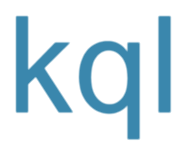

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
#Imports
from azure.kusto.data.request import KustoClient, KustoConnectionStringBuilder
from azure.kusto.data.exceptions import KustoServiceError

import numpy as np
import scipy.linalg as lin
import Levenshtein as leven
from IPython import get_ipython
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import interactive, Layout, Select, IntSlider

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
import itertools
import networkx as nx

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 200)

# KqlMagic
%reload_ext Kqlmagic
%config Kqlmagic.auto_dataframe=True

### KqlMagic
Documentation https://github.com/mbnshtck/jupyter-kql-magic/blob/master/README.rst

Quickstart Notebook https://github.com/mbnshtck/jupyter-kql-magic/blob/master/notebooks/QuickStart.ipynb

In [6]:
# Kusto utility functions
# Allows printing of query with stripped commments and newline chars
def print_kql(query):
    print(clean_kql_query(query))

def clean_kql_query(query_string):
    import re
    return re.sub(r'(//[^\"\'\n]+)', '', query_string, re.MULTILINE).replace('\n', '').strip()

def execute_kql_query(query_string):
    if not query_string or len(query_string.strip()) == 0:
        print('No query supplied')
        return None
    src_query = clean_kql_query(query_string)
    magic_string = f'results_frame << {src_query}'
    magic_string = magic_string
    ip = get_ipython()
    ip.run_line_magic('kql', magic_string)
    return results_frame

In [7]:
# Select a LA workspace id from some demo environments
from ipywidgets import widgets, Select, Layout, interactive
available_workspaces = {'ASIHuntOMSWorkspaceV4': '52b1ab41-869e-4138-9e40-2a4457f09bf0',
                        'ASIHuntOMSWorkspaceV5': '4ca7b24a-6e8f-4540-a8ce-1a80c2948c37',
                        'Contoso77':'802d39e1-9d70-404d-832c-2de5e2478eda', 
                        'MSTICLinux':'06dc719f-5dad-47e9-b5af-07d84a0bda4e',
                        'Rome ILDC - Detection E2E Tests Stage': '3eb61071-5dcd-4db3-94fa-0091a69b7359' }

alertId = ''
def select_workspace(x=''):
    global workspace_id
    workspace_id = available_workspaces[x]
     
selected_workspace = widgets.Select(options=available_workspaces.keys(), 
                              description='Select workspace :',
                              layout=Layout(width='50%', height='100px'),
                              style = {'description_width': 'initial'})
interactive(select_workspace, x=selected_workspace)

interactive(children=(Select(description='Select workspace :', layout=Layout(height='100px', width='50%'), opt…

In [194]:
# Kusto authentication
#%kql kusto://code().cluster('Ascprodus').database('ProdAlerts')
    
# Log Analytics authentication
%kql loganalytics://code().workspace(workspace_id)

# Sample office hunting and investigation

In [202]:
# Look for unusual signins - eg associated with multiple IPs within short timeframe

from ipywidgets import widgets, Select, Layout, interactive, Button, HBox, VBox

unusual_signin_query = """
let timeRange=ago(60d);
let officeAuthentications = OfficeActivity
| where TimeGenerated >= timeRange
| where RecordType in ("AzureActiveDirectoryAccountLogon", "AzureActiveDirectoryStsLogon")
| extend UserAgent = extractjson("$[0].Value", ExtendedProperties, typeof(string))
| where Operation == "UserLoggedIn";
let lookupWindow = 1d;
let lookupBin = lookupWindow / 2.0; 
officeAuthentications | project-rename Start=TimeGenerated
| extend TimeKey = bin(Start, lookupBin)
| join kind = inner (
    officeAuthentications
    | project-rename End=TimeGenerated
    | extend TimeKey = range(bin(End - lookupWindow, lookupBin), bin(End, lookupBin), lookupBin)
    | mvexpand TimeKey to typeof(datetime)
) on UserAgent, TimeKey
| project timeSpan = End - Start, UserId, ClientIP , UserAgent , Start, End
| summarize dcount(ClientIP) by  UserAgent
| where dcount_ClientIP > 1
| join kind=inner (  
officeAuthentications
| summarize minTime=min(TimeGenerated), maxTime=max(TimeGenerated), dcount(ClientIP) by UserId, UserAgent
| project UserId, dcount_ClientIP , timeSpan = maxTime-minTime, UserAgent
| project UserId, distinctIPCount=dcount_ClientIP, timeSpan, UserAgent) on UserAgent
| project UserAgent, UserId, distinctIPCount
"""

unusual_signing_results = execute_kql_query(unusual_signin_query)
user_agents = unusual_signing_results.groupby('UserAgent')

def select_user_id(user_id):
    global selected_user_id
    selected_user_id = user_id

def select_user_agent(user_agent):
    global selected_user_agent
    selected_user_agent = user_agent

    user_id_dropdown.options = user_agents.get_group(user_agent).get('UserId').values
    
user_agent_dropdown = widgets.Dropdown(options=user_agents.groups.keys())
init_user_agent_dropdown = user_agent_dropdown.value
user_id_dropdown = widgets.Dropdown(options=user_agents.get_group(init_user_agent_dropdown).get('UserId').values)

interactive_user_id = widgets.interactive(select_user_id, user_id=user_id_dropdown)
interactive_user_agent = widgets.interactive(select_user_agent, user_agent=user_agent_dropdown)

left_box = VBox([user_agent_dropdown])
right_box = VBox([user_id_dropdown])
HBox([left_box, right_box])

In [203]:
print("User Agent:", selected_user_agent, "User ID:", selected_user_id)

User Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36 User ID: tenantadmin@Testgg636753129.onmicrosoft.com


In [204]:
# the query above returns counts for UA/UserId combinations
# So from there it would be good to pick one of the user agents and list all the signins for that UserID/UA
user_agent_signin_query = """
let timeRange=ago(60d);
let officeAuthentications =
OfficeActivity
| where TimeGenerated >= timeRange
| where RecordType in ("AzureActiveDirectoryAccountLogon", "AzureActiveDirectoryStsLogon")
| extend UserAgent = extractjson("$[0].Value", ExtendedProperties, typeof(string))
| where Operation == "UserLoggedIn";
officeAuthentications
| where UserId == "{user_id}" 
| where UserAgent == "{user_agent}"
| project TimeGenerated , UserId, Operation , ClientIP , UserAgent 
""".format(user_id=selected_user_id, user_agent=selected_user_agent)

user_agent_signin_results = execute_kql_query(user_agent_signin_query)
display(user_agent_signin_results)

,TimeGenerated,UserId,Operation,ClientIP,UserAgent
0,2018-11-07 18:55:59,tenantadmin@Testgg636753129.onmicrosoft.com,UserLoggedIn,131.107.159.104,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36"
1,2018-11-07 18:56:06,tenantadmin@Testgg636753129.onmicrosoft.com,UserLoggedIn,131.107.159.104,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36"
2,2018-11-07 18:56:06,tenantadmin@Testgg636753129.onmicrosoft.com,UserLoggedIn,131.107.159.104,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36"
3,2018-11-07 18:56:07,tenantadmin@Testgg636753129.onmicrosoft.com,UserLoggedIn,131.107.159.104,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36"
4,2018-11-07 18:56:07,tenantadmin@Testgg636753129.onmicrosoft.com,UserLoggedIn,131.107.159.104,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36"
5,2018-11-07 18:56:09,tenantadmin@Testgg636753129.onmicrosoft.com,UserLoggedIn,131.107.159.104,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36"
6,2018-11-07 18:56:51,tenantadmin@Testgg636753129.onmicrosoft.com,UserLoggedIn,131.107.159.104,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36"
7,2018-11-07 18:56:52,tenantadmin@Testgg636753129.onmicrosoft.com,UserLoggedIn,131.107.159.104,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36"
8,2018-11-07 18:56:52,tenantadmin@Testgg636753129.onmicrosoft.com,UserLoggedIn,131.107.159.104,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36"
9,2018-11-07 18:56:52,tenantadmin@Testgg636753129.onmicrosoft.com,UserLoggedIn,131.107.159.104,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36"


count
Country       ClientIP              
United States 131.107.159.104     19
              167.220.2.232        6

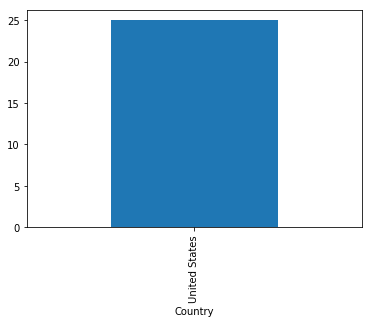

In [208]:
from geolite2 import geolite2

def get_geo(ip_array):
    geo_list = []
    for ip in ip_array:
        geo_match = geo.get(ip)
        geo_result = {
            'City': geo_match.get('city', {}).get('names', {}).get('en', 'Unknown'), 
            'Country': geo_match.get('country', {}).get('names', {}).get('en', 'Unknown'),
            'Country Code': geo_match.get('country', {}).get('iso_code', 'Unknown'),
            'Latitude': geo_match.get('location', {}).get('latitude', 'Unknown'),
            'Longitude': geo_match.get('location', {}).get('longitude', 'Unknown'),
            'IP': ip
        }
        geo_list.append(geo_result)
    return pd.DataFrame(data=geo_list)

geo = geolite2.reader()

user_agent_signin_results_geo = user_agent_signin_results.merge(get_geo(user_agent_signin_results['ClientIP'].unique()), left_on='ClientIP', right_on='IP')

display(user_agent_signin_results_geo.groupby(['Country', 'ClientIP'])['ClientIP'].agg(['count']))
display(user_agent_signin_results_geo.groupby(['Country'])['ClientIP'].count().plot.bar())